In [84]:
import tensorflow as tf
from tensorflow import keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten,BatchNormalization,Conv2D,MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
 
import numpy as np
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
%matplotlib inline

In [8]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print("Num GPUs Available: ",len(physical_devices))
#tf.config.experimental.set_memory_growth(physical_devices[0],True)

Num GPUs Available:  0


# Data preparation

image have amikacin and cefazolin 100 images in each type

In [ ]:
("C:\Users\captain\0-Handwritten CNN\binarized_image\amikacin\amikacin_1.png)

In [10]:
#Organize data into train , valid , teset dirs
os.chdir('data/amikacin-cefazolin')
if os.path.isdir('train/amikacin') is False:
    os.makedirs('train/amikacin')
    os.makedirs('train/cefazolin')
    os.makedirs('valid/amikacin')
    os.makedirs('valid/cefazolin')
    os.makedirs('test/amikacin')
    os.makedirs('test/cefazolin')
    
    for c in random.sample(glob.glob("amikacin*"),80):
        shutil.move(c,'train/amikacin')
    for c in random.sample(glob.glob("cefazolin*"),80):
        shutil.move(c,'train/cefazolin')
    #for c in random.sample(glob.glob("amikacin*"),10):
    #    shutil.move(c,'valid/amikacin')
    #for c in random.sample(glob.glob("cefazolin*"),10):
    #    shutil.move(c,'valid/cefazolin')
    for c in random.sample(glob.glob("amikacin*"),20):
        shutil.move(c,'test/amikacin')
    for c in random.sample(glob.glob("cefazolin*"),20):
        shutil.move(c,'test/cefazolin')
os.chdir("../../")

In [73]:
train_path = 'data/amikacin-cefazolin/train'
valid_path = 'data/amikacin-cefazolin/valid'
test_path = 'data/amikacin-cefazolin/test'
                                            
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
	.flow_from_directory(directory=train_path,target_size=(224,224),classes=['amikacin','cefazolin'],batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
	.flow_from_directory(directory=valid_path,target_size=(224,224),classes=['amikacin','cefazolin'],batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
	.flow_from_directory(directory=test_path,target_size=(224,224),classes=['amikacin','cefazolin'],batch_size=10,shuffle=False)

Found 160 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [75]:
#Verified data
assert train_batches.n == 160
#assert valid_batches.n == 
assert test_batches.n == 40


In [76]:
imgs, labels = next(train_batches)

In [77]:
# This function will plot images in the form of a grid with 1 row and 10 columns where images are place
def plotImages (images_arr):
    fig, axes = plt.subplots(1,10, figsize= (15,15))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [78]:
print(len(imgs))

10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

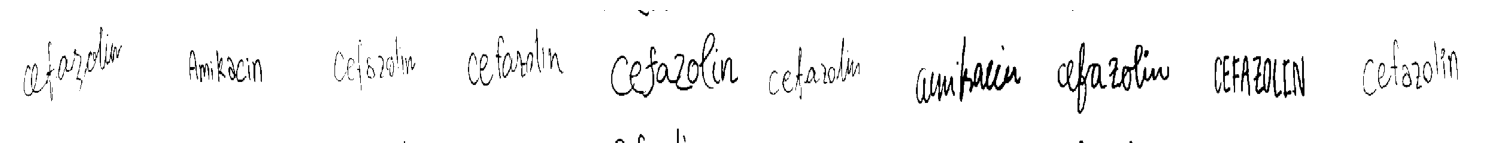

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [79]:
plotImages(imgs)
print(labels)

In [31]:
#in model.fit step per epoch = training sample/batches size
#e.g. 100/5 = 20 = step per epoch
#if pass validation data. we need to pass validation_steps


# Build and train CNN 

In [41]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation= 'relu', padding = 'same', input_shape= (224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation= 'relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    #units = output node (num_class)
    Dense(units=2, activation='softmax'),
    
])

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 200704)            0         
                                                                 
 dense_1 (Dense)             (None, 2)                

In [43]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=['accuracy'])

In [45]:
model.fit(x=train_batches,validation_data=valid_batches,epochs=10,verbose=2)

Epoch 1/10
16/16 - 3s - loss: 195.4919 - accuracy: 0.5437 - 3s/epoch - 217ms/step
Epoch 2/10
16/16 - 3s - loss: 64.3906 - accuracy: 0.5562 - 3s/epoch - 167ms/step
Epoch 3/10
16/16 - 3s - loss: 15.4509 - accuracy: 0.7500 - 3s/epoch - 168ms/step
Epoch 4/10
16/16 - 3s - loss: 10.0384 - accuracy: 0.8125 - 3s/epoch - 168ms/step
Epoch 5/10
16/16 - 3s - loss: 4.2136 - accuracy: 0.9000 - 3s/epoch - 173ms/step
Epoch 6/10
16/16 - 3s - loss: 1.6913 - accuracy: 0.9750 - 3s/epoch - 170ms/step
Epoch 7/10
16/16 - 3s - loss: 0.1653 - accuracy: 0.9875 - 3s/epoch - 165ms/step
Epoch 8/10
16/16 - 3s - loss: 0.4244 - accuracy: 0.9750 - 3s/epoch - 167ms/step
Epoch 9/10
16/16 - 3s - loss: 0.3009 - accuracy: 0.9812 - 3s/epoch - 174ms/step
Epoch 10/10
16/16 - 3s - loss: 0.0111 - accuracy: 0.9937 - 3s/epoch - 169ms/step


## Vggnet model section

In [123]:
from tensorflow.keras.layers import Input, MaxPooling2D
from tensorflow.keras.models import Model

In [133]:
_input = Input((224,224,3))

conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(_input)
conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv1)
pool1  = MaxPooling2D((2, 2))(conv2)

conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool1)
conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv3)
pool2  = MaxPooling2D((2, 2))(conv4)

conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv5)
conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv6)
pool3  = MaxPooling2D((2, 2))(conv7)

conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv8)
conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv9)
pool4  = MaxPooling2D((2, 2))(conv10)

conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
pool5  = MaxPooling2D((2, 2))(conv13)

flat   = Flatten()(pool5)
dense1 = Dense(4096, activation="relu")(flat)
dense2 = Dense(4096, activation="relu")(dense1)
output = Dense(2, activation="softmax")(dense2)

vgg16_model  = Model(inputs=_input, outputs=output)

In [135]:
vgg16_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_36 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_37 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_39 (Conv2D)          (None, 112, 112, 128)     147584    
                                                           

In [136]:
vgg16_model.compile(optimizer=Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=['accuracy'])

In [137]:
vgg16_model.fit(x=train_batches,validation_data=valid_batches,epochs=10,verbose=2)

Epoch 1/10
16/16 - 73s - loss: 1.1239 - accuracy: 0.5375 - 73s/epoch - 5s/step
Epoch 2/10
16/16 - 70s - loss: 0.6056 - accuracy: 0.6687 - 70s/epoch - 4s/step
Epoch 3/10
16/16 - 69s - loss: 0.2991 - accuracy: 0.8500 - 69s/epoch - 4s/step
Epoch 4/10
16/16 - 64s - loss: 0.1948 - accuracy: 0.9375 - 64s/epoch - 4s/step
Epoch 5/10
16/16 - 65s - loss: 0.2052 - accuracy: 0.9563 - 65s/epoch - 4s/step
Epoch 6/10
16/16 - 63s - loss: 0.1185 - accuracy: 0.9500 - 63s/epoch - 4s/step
Epoch 7/10
16/16 - 67s - loss: 0.0106 - accuracy: 1.0000 - 67s/epoch - 4s/step
Epoch 8/10
16/16 - 67s - loss: 0.0452 - accuracy: 0.9812 - 67s/epoch - 4s/step
Epoch 9/10
16/16 - 73s - loss: 0.0464 - accuracy: 0.9875 - 73s/epoch - 5s/step
Epoch 10/10
16/16 - 68s - loss: 0.0852 - accuracy: 0.9750 - 68s/epoch - 4s/step


In [155]:
# save the trained model
vgg16_model.save('vgg16.h5')

In [160]:
# Evaluate the model on the test set
test_loss, test_acc = vgg16_model.evaluate(train_batches)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_acc}')

16/16 [==============================] - 11s 674ms/step - loss: 0.0061 - accuracy: 1.0000
Test loss: 0.006078267004340887
Test accuracy: 1.0


In [161]:
# Evaluate the model on the test set
# Evaluate the model on the test set
test_loss, test_acc = vgg16_model.evaluate(test_batches)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_acc}')


4/4 [==============================] - 3s 743ms/step - loss: 0.1868 - accuracy: 0.9250
Test loss: 0.18684805929660797
Test accuracy: 0.925000011920929


# Predict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

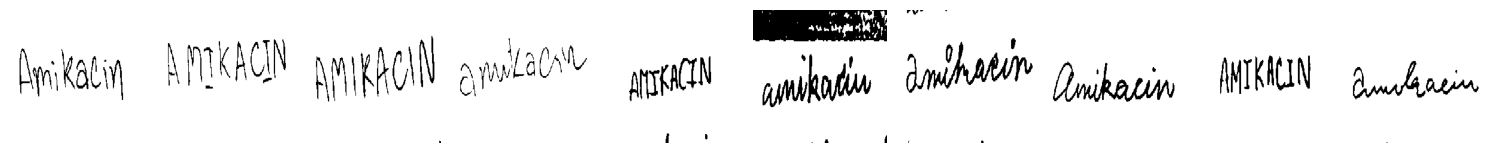

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [139]:
test_imgs,test_labels=next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [140]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [148]:
predictions = vgg16_model.predict(x=test_batches,verbose=0)

In [149]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [150]:
#This is full probality of prediction confident
predictions

array([[9.99999881e-01, 1.31813593e-07],
       [9.99977112e-01, 2.28943627e-05],
       [9.99700308e-01, 2.99748644e-04],
       [9.99994278e-01, 5.71316878e-06],
       [9.99999762e-01, 2.32147585e-07],
       [9.99990702e-01, 9.31100840e-06],
       [9.99998808e-01, 1.16894182e-06],
       [9.99999642e-01, 3.66546033e-07],
       [9.99996901e-01, 3.04406012e-06],
       [9.99998212e-01, 1.77966047e-06],
       [1.00000000e+00, 1.47324167e-10],
       [9.98292744e-01, 1.70720823e-03],
       [9.99996066e-01, 3.98405518e-06],
       [9.99832630e-01, 1.67389662e-04],
       [9.98538494e-01, 1.46155455e-03],
       [9.99999285e-01, 6.61889487e-07],
       [1.00000000e+00, 2.13222826e-08],
       [1.00000000e+00, 2.98483127e-09],
       [9.99999762e-01, 2.94733752e-07],
       [1.00000000e+00, 7.71661068e-11],
       [3.37557867e-02, 9.66244280e-01],
       [1.49924442e-01, 8.50075603e-01],
       [2.90931494e-04, 9.99709070e-01],
       [3.07251757e-04, 9.99692798e-01],
       [2.865178

In [151]:
cm = confusion_matrix(y_true = test_batches.classes,y_pred=np.argmax(predictions,axis=-1))

In [152]:
def plot_confusion_matrix(cm,classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting "normalize=True`.
    """
    plt.imshow(cm, interpolation= 'nearest',cmap="Blues")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel("True label")
        plt.xlabel("Predicted label")

In [153]:
test_batches.class_indices

{'amikacin': 0, 'cefazolin': 1}

Confusion matrix, without normalization
[[20  0]
 [ 3 17]]


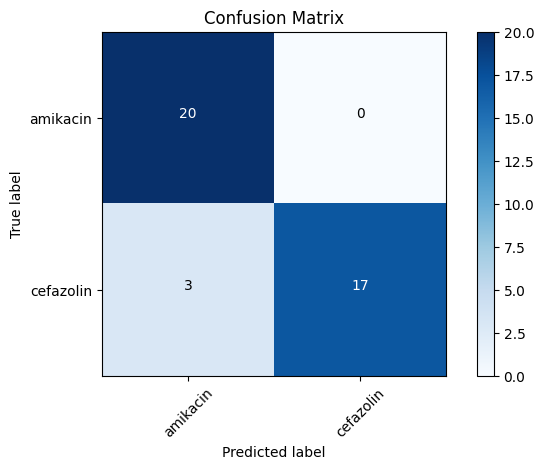

In [154]:
# labels instead classes argument
cm_plot_labels = ['amikacin','cefazolin']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title="Confusion Matrix")